In [2]:
import os, shutil

In [3]:
from keras.applications.vgg16 import VGG16  # dl VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import load_img, img_to_array 
# cannot import name 'load_img' from 'keras.preprocessing.image' 

from keras.utils import image_utils  # use load_img, img_to_array from here
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt


In [4]:
vgg16_model = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
# 使用imagenet数据集训练
# only conv and pool
# top 在之后加
# Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
# dl manually and put it on C:\Users\Administrator\.keras\models


![2022-12-06_14-06-25](./ping_log/Snipaste_2022-12-06_14-06-25.png)

In [5]:
# top
top_model = Sequential() # 图片输出四维，1代表数量
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))


In [15]:
model = Sequential()
model.add(vgg16_model)
model.add(top_model)


In [16]:
print(model.summary())
print(vgg16_model.summary())
print(top_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 2097922   
                                                                 
Total params: 16,812,610
Trainable params: 16,812,610
Non-trainable params: 0
_________________________________________________________________
None
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)

In [17]:
# 数据增强！ 跟那个cnn一样
# 区分训练集和测试集
# cnn没有在数据增强的时候做数据归一化，vgg数据归一化因为看到有文章说VGG和ResNet归一化会好一点

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,  # 数据归一化
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',  # 填充新创建像素的方法
)

test_datagen = ImageDataGenerator(
    rescale=1/255,  # 数据归一化
)

batch = 20  # 20 pre training as same as cnn

train_dir = 'data_use/train/'
test_dir = 'data_use/test/'
validation_dir = 'data_use/validation/'

# 猫训练图片所在目录
train_cats_dir = os.path.join(train_dir, 'cats')

# 狗训练图片所在目录
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 猫验证图片所在目录
validation_cats_dir = os.path.join(validation_dir, 'cats')

# 狗验证数据集所在目录
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# 猫测试数据集所在目录
test_cats_dir = os.path.join(test_dir, 'cats')

# 狗测试数据集所在目录
test_dogs_dir = os.path.join(test_dir, 'dogs')


In [18]:
# 生成训练数据
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 从训练集这个目录生成数据
    target_size=(150, 150),  # 把生成数据大小定位150*150
    batch_size=batch,
)
# 测试数据
test_generator = test_datagen.flow_from_directory(
    test_dir,  # 从训练集这个目录生成数据
    target_size=(150, 150),  # 把生成数据大小定位150*150
    batch_size=batch,
)
# 验证数据
validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # 从训练集这个目录生成数据
    target_size=(150, 150),  # 把生成数据大小定位150*150
    batch_size=batch,
)

# 查看定义类别分类
print(train_generator.class_indices)
print(test_generator.class_indices)
print(validation_generator.class_indices)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [10]:
# 优化器 损失函数 准确率
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
# 每张训练1次 设定验证集
model.fit(train_generator,
                    epochs=1,
                    validation_data=validation_generator)
# do not use lr but learning_rate
# use model.fit 
# steps_per_epoch=100
# validation_steps

100/100 [==============================] - 564s 6s/step - loss: 0.6996 - accuracy: 0.6005 - val_loss: 0.4816 - val_accuracy: 0.8030


In [12]:
# 额，在上一个块儿那挂了两次，好无助
model.save('cats_and_dogs_vgg_wip.h5')

In [20]:
# 优化器 损失函数 准确率
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

# skip the 2 up block and run this block and goon
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=4,  # 迭代次数
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/4
100/100 [==============================] - 554s 6s/step - loss: 0.2231 - accuracy: 0.9045 - val_loss: 0.2050 - val_accuracy: 0.9200
Epoch 2/4
100/100 [==============================] - 576s 6s/step - loss: 0.2157 - accuracy: 0.9115 - val_loss: 0.1398 - val_accuracy: 0.9460
Epoch 3/4
100/100 [==============================] - 571s 6s/step - loss: 0.1876 - accuracy: 0.9255 - val_loss: 0.1505 - val_accuracy: 0.9420
Epoch 4/4
100/100 [==============================] - 561s 6s/step - loss: 0.1826 - accuracy: 0.9310 - val_loss: 0.1235 - val_accuracy: 0.9550


In [21]:
# 额，在上一个块儿那挂了三次，好无助
model.save("cats_and_dogs_vgg.h5")

In [22]:
import matplotlib.pyplot as plt

In [23]:
print(history.history)

{'loss': [0.22307689487934113, 0.21569284796714783, 0.18758514523506165, 0.18255844712257385], 'accuracy': [0.9045000076293945, 0.9114999771118164, 0.9254999756813049, 0.9309999942779541], 'val_loss': [0.2050267606973648, 0.13983993232250214, 0.1505006104707718, 0.1234559416770935], 'val_accuracy': [0.9200000166893005, 0.9459999799728394, 0.9419999718666077, 0.9549999833106995]}


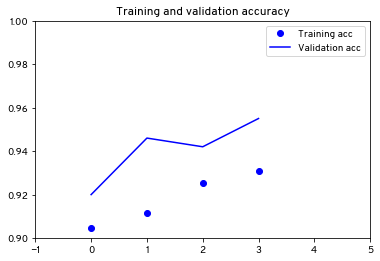

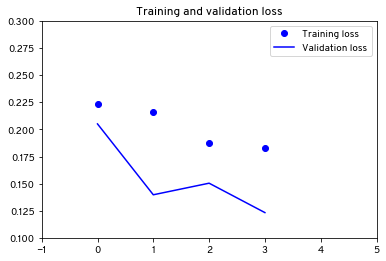

In [29]:
acc = history.history['accuracy']  # history.history is a dict type
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.rcParams['font.sans-serif'] = 'Overpass'

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlim([-1, 5])
plt.ylim([0.9, 1])
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlim([-1, 5])
plt.ylim([0.1, 0.3])
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [30]:
# end
